In [88]:
from dataclasses import dataclass
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('svg')

@dataclass
class Database:
    uri = f"postgresql+psycopg2://postgres:@localhost:5432/dns_mac"

    def __init__(self):
        self.engine = create_engine(self.uri)
        # self.conn = self.engine.connect()
        pass

db = Database()

pcaps = [('caphaw', 54), ('zbot', 46), ('simda', 58), ('unknown', 57)]

In [217]:
'''
id, pcap_id, time_s, time_s_translated, fn, fn_req, dn_id,
dn, bdn, qcode, is_r, rcode, server, answer,
pcap_infected, pcap_malware_type, rn, rn_qr, rn_qr_rcode,
eps1, eps2, eps3, eps4, rank_dn, rank_bdn
'''
def get_df(mwname, pcap_id):
    df = pd.read_sql(f"""
    SELECT time_s_translated, FLOOR(time_s_translated / 3600) as "hour" from public.get_message_pcap_all3(
        {pcap_id},
        0
    )
    --where rn_qr_rcode=1 and rcode=3 and FLOOR(time_s_translated / 3600) < 24*30
    where rn_qr=1 and is_r is false
    """, db.engine)

    df["p"] = 1

    df = df.groupby("hour").aggregate({"p": 'sum'})
    idx  = df.index.to_numpy().astype(int)

    index2 = []
    missing = []
    for i in range(idx.max()):
        if i not in idx:
            index2.append(i)
            missing.append(0)

    return pd.concat([df, pd.Series(missing, index2, name='p')]).sort_index()

In [ ]:
FPR = 0.00009
TPR = 0.999916

freq_n_s = [
    5,
    50,
    500,
    1000,
    35e6 / 30*24,
]

for freq_n in freq_n_s:
    print(freq_n)
    for mwname, pcap_id in pcaps:
        df = get_df(mwname, pcap_id)

        print(f'{mwname}:')
        for m in ['max', 'mean']:
            if m == 'max':
                FREQ_P = df.iloc[:30*24].max().item()
            elif m == 'mean':
                FREQ_P = df.iloc[:30*24].mean().item()

            P_n = freq_n / (freq_n + FREQ_P)
            P_p = FREQ_P / (freq_n + FREQ_P)

            eq = f"{P_p:10.4g} * {TPR:10.4g} >= {P_n:10.4g} * {FPR:10.4g}"
            diseq = f'{P_p * TPR:.4g} - {P_n * FPR:.4g} >= 0'
            diseqv = f'{P_p * TPR - P_n * FPR:.4g} >= 0'
            print(f'\t{m:4}:\t\t\t{diseq:30}\t{diseqv:30}\t\t{(P_n * FPR)/(P_p * TPR):>20.5g} << 1')
            pass
        print()
        pass
    print()
    pass

print("Probabilità di avere un falso positivo << Probabilità di avere un vero positivo")
print("""
 Probabilità di avere un falso positivo
---------------------------------------- = Numero di falsi positivi per veri positivi
 Probabilità di avere un vero positivo
      
""")



In [ ]:
FPR = 0.00009
TPR = 0.999916

pd.options.display.max_columns = None

freq_n_s = [
    5,
    # 50,
    # 500,
    # 1000,
    35e6 / 30*24,
]

_print = False
__print = lambda *args, **kwargs, : print(*args, **kwargs) if _print else None
values = []
for freq_n in freq_n_s:
    __print(freq_n)
    for mwname, pcap_id in pcaps:
        df = get_df(mwname, pcap_id)

        __print(f'{mwname}:')
        for n_r in [0.9]: #[1, 10, 50, 500, 1000]:
            n = n_r * freq_n
            __print(f'n={n}:', end='\n')
            for m in ['mean']: #['min', 'max', 'mean']:
                if m == 'max':
                    FREQ_P = df.iloc[:30*24].max().item()
                elif m == 'mean':
                    FREQ_P = df.iloc[:30*24].mean().item()

                P_n = freq_n / (freq_n + FREQ_P)
                P_p = FREQ_P / (freq_n + FREQ_P)

                p_rate = (1/n) * P_p * TPR
                n_rate = (1/n) * P_n * FPR

                eq = f"1/{n} * {P_p:10.4g} * {TPR:10.4g} >= 1/{n} * {P_n:10.4g} * {FPR:10.4g}"
                diseq = f'{p_rate:.4g} - {n_rate:.4g} >= 0'
                diseqv = f'{p_rate - n_rate:.4g} > 0'
                __print(f'\t{m:4}:\t\t\t{diseq:30}\t{diseqv:30}\t\t{(n_rate)/(p_rate):>20.5g} << 1')

                values.append([
                    freq_n,
                    mwname,
                    n_r,
                    # {'max':0, 'min':1, 'mean': 2}[m],
                    m,
                    P_n,
                    P_p,
                    n_rate,
                    p_rate,
                    p_rate - n_rate,
                    # diseq,
                    # diseqv
                ])
                pass
            pass
        __print()
        pass
    __print()
    pass

DF = pd.DataFrame(values, columns=[
    "freq_n",
    'mwname',
    "n_perc",
    "m",
    "P_n",
    "P_p",
    "Rate_n",
    "Rate_p",
    "Rate_balance"
])

display(DF)

print("Probabilità di avere un falso positivo << Probabilità di avere un vero positivo")
print("""
 Probabilità di avere un falso positivo
---------------------------------------- = Numero di falsi positivi per veri positivi
 Probabilità di avere un vero positivo
      
""")



      time_s_translated    hour  p
0          0.000000e+00     0.0  1
1          4.767477e+02     0.0  1
2          5.371778e+02     0.0  1
3          5.411131e+02     0.0  1
4          6.690783e+02     0.0  1
...                 ...     ... ..
5741       3.616983e+06  1004.0  1
5742       3.617886e+06  1004.0  1
5743       3.618387e+06  1005.0  1
5744       3.618391e+06  1005.0  1
5745       3.618391e+06  1005.0  1

[5746 rows x 3 columns]


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


      time_s_translated    hour  p
0          0.000000e+00     0.0  1
1          3.128077e+02     0.0  1
2          3.131381e+02     0.0  1
3          3.156567e+02     0.0  1
4          1.067279e+03     0.0  1
...                 ...     ... ..
4297       3.633296e+06  1009.0  1
4298       3.634780e+06  1009.0  1
4299       3.635527e+06  1009.0  1
4300       3.636273e+06  1010.0  1
4301       3.637007e+06  1010.0  1

[4302 rows x 3 columns]


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


      time_s_translated   hour  p
0          0.000000e+00    0.0  1
1          4.902449e+02    0.0  1
2          5.598078e+02    0.0  1
3          5.711846e+02    0.0  1
4          5.731636e+02    0.0  1
...                 ...    ... ..
2981       3.014095e+06  837.0  1
2982       3.014096e+06  837.0  1
2983       3.014130e+06  837.0  1
2984       3.014131e+06  837.0  1
2985       3.014836e+06  837.0  1

[2986 rows x 3 columns]


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


      time_s_translated   hour  p
0          0.000000e+00    0.0  1
1          1.001865e+03    0.0  1
2          1.002051e+03    0.0  1
3          1.848558e+05   51.0  1
4          3.399102e+05   94.0  1
...                 ...    ... ..
2022       2.363349e+06  656.0  1
2023       2.718580e+06  755.0  1
2024       2.718583e+06  755.0  1
2025       3.189002e+06  885.0  1
2026       3.220056e+06  894.0  1

[2027 rows x 3 columns]


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_37319/557247778.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


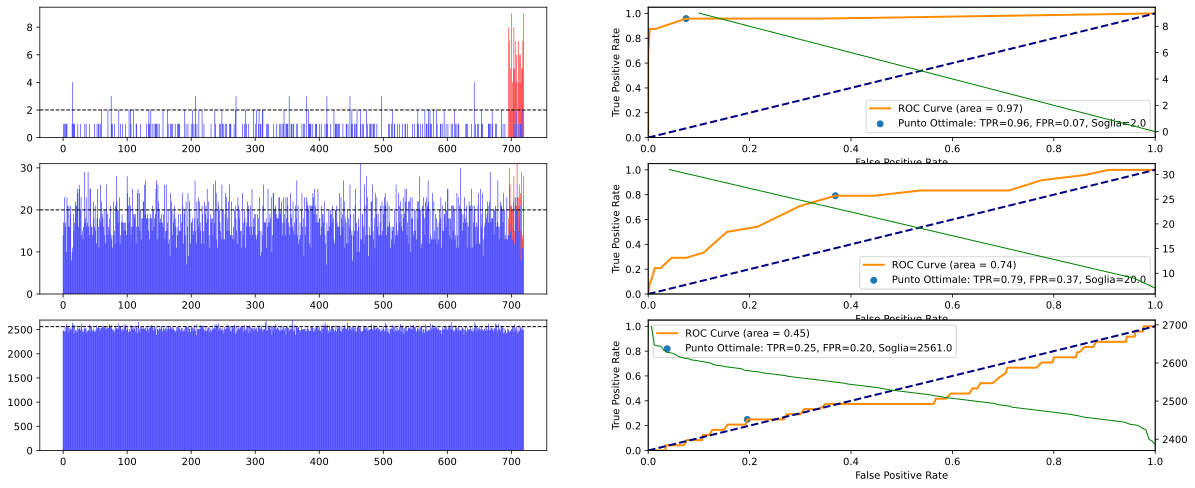

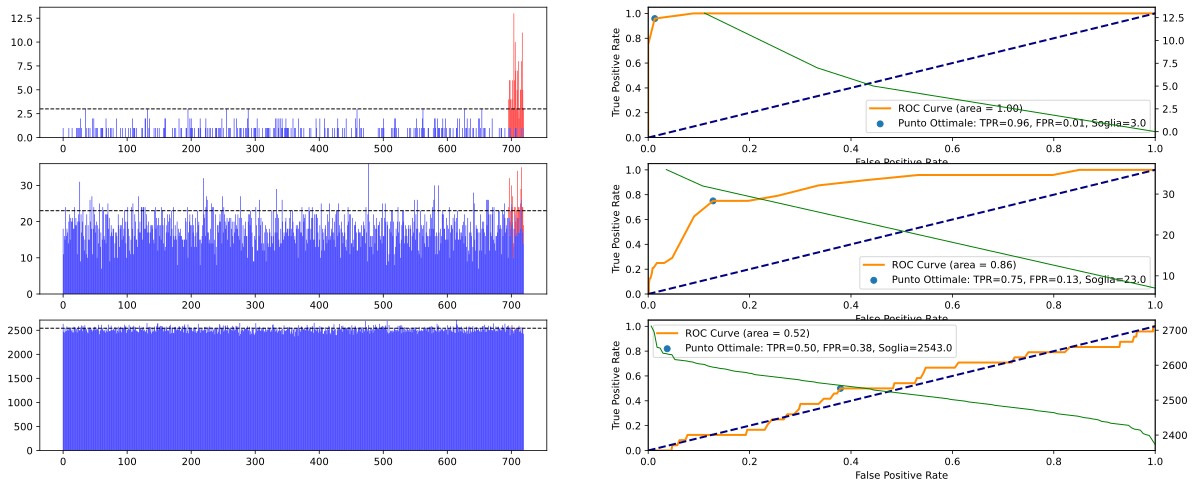

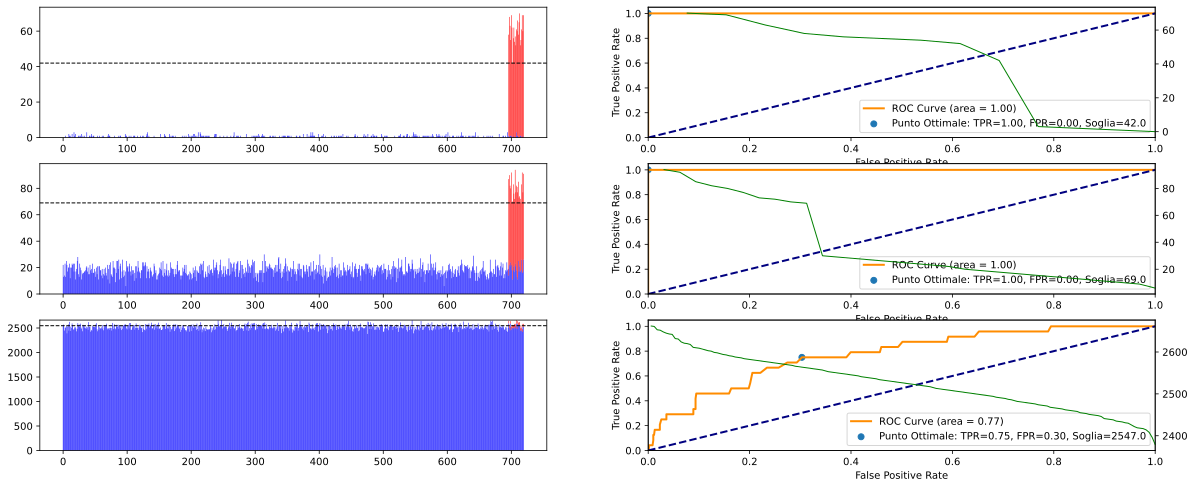

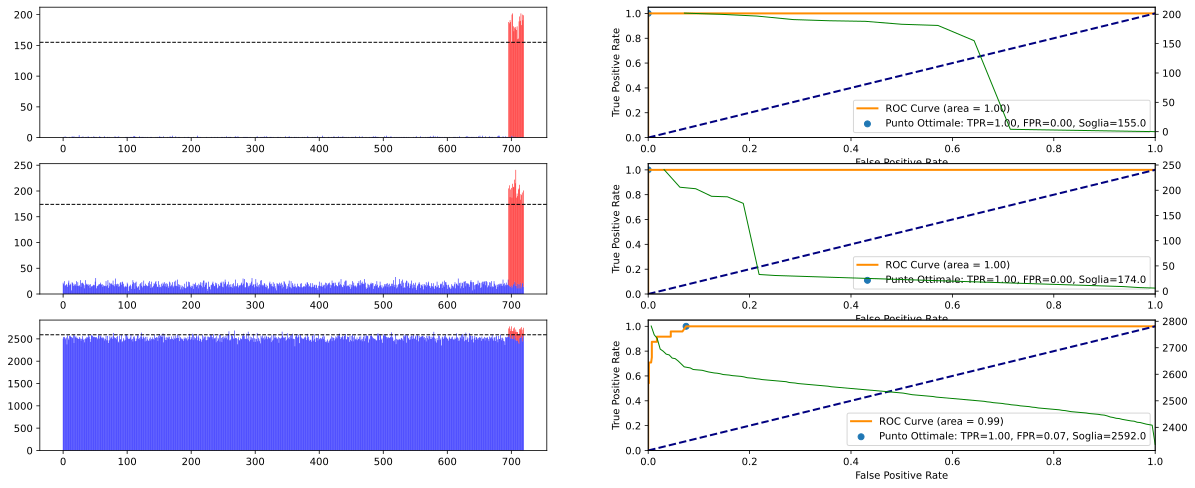

In [218]:
import enum
from typing import Optional
from scipy.stats import nbinom


FPR = 0.00009
TPR = 0.999916

class PDFRNG(enum.Enum):
    POISSON = 0
    PASCAL = 1
    pass

@dataclass()
class PDF:
    n: int

    mu_n: float
    mu_p: float

    _sigma_n: Optional[float]
    sigma_p: float

    FPR: float
    TPR: float

    discost: float = 0.5
    discost_prob: float = 0.4
    rng = np.random.default_rng()

    @property
    def mu_fp(self):
        return self.mu_n * FPR

    @property
    def mu_tp(self):
        return self.mu_p * TPR

    @property
    def sigma_n(self) -> float:
        if self._sigma_n is None:
            raise Exception('Sigma N not calculated or unset.')
        return self._sigma_n

    @property
    def sigma_fp(self) -> float:
        return self.sigma_n * FPR

    @property
    def sigma_tp(self):
        return self.sigma_p * TPR

    def _sigma(self, mu, discost, prob_discost):
        Z_high = norm.ppf(0.5 + prob_discost / 2)
        sigma = (discost * mu) / Z_high
        return sigma
    
    def set_sigma_n(self, discost, prob_discost=0.4):
        self.discost = discost
        self.prob_discost = prob_discost
        Z_high = norm.ppf(0.5 + prob_discost / 2)
        self._sigma_n = (discost * self.mu_n) / Z_high
        return self
    
    def _negbin(self, mu, sigma, n_samples):
        sigma_squared = sigma**2
        r = mu**2 / (sigma_squared - mu)
        p = r / (r + mu)
        # return np.random.Generator.negative_binomial(self.mu_n, 1 - self.FPR, size=n_samples)
        return np.random.Generator.poisson(self.mu_n * self.FPR, size=n_samples)
    
    def _negbin_cdf(self, mu, sigma, thresholds):
        print(mu, sigma)
        sigma_squared = (sigma)**2
        r = mu**2 / (sigma_squared - mu)
        p = r / (r + mu)
        return [1 - nbinom.cdf(t, r, p) for t in thresholds]
    
    def fp_negbin_cdf(self, thresholds):
        return self._negbin_cdf(self.mu_fp, self.sigma_fp, thresholds)
    
    def tp_negbin_cdf(self, thresholds):
        return self._negbin_cdf(self.mu_tp, self.sigma_tp, thresholds)
    
    def _negbin_gen(self, mu, sigma, n_samples):
        sigma_squared = (sigma)**2
        r = mu**2 / (sigma_squared - mu)
        p = r / (r + mu)
        # return np.random.negative_binomial(r, p, size=n_samples)
        return self.rng.negative_binomial(self.mu_n, 1 - self.FPR, size=n_samples)
        # return self.rng.poisson(self.mu_n * self.FPR, size=n_samples)
    
    def _poisson_gen(self, lam, n_samples):
        return self.rng.poisson(lam, size=n_samples)
    
    def _pascal_gen(self, r, p, n_samples):
        return self.rng.negative_binomial(r, p, size=n_samples)

    def fp_gen(self, rng: PDFRNG, n_samples: int):
        if rng == PDFRNG.POISSON:
            return self._poisson_gen(self.mu_n * self.FPR, n_samples)
        elif rng == PDFRNG.PASCAL:
            return self._pascal_gen(self.mu_n, 1 - self.FPR, n_samples)
        else:
            raise Exception(f"Distribution {rng} not supported.")
    
    def tp_gen(self, rng: PDFRNG, n_samples: int):
        if rng == PDFRNG.POISSON:
            return self._poisson_gen(self.mu_p * self.TPR, n_samples)
        elif rng == PDFRNG.PASCAL:
            return self._pascal_gen(self.mu_p, self.TPR, n_samples)
        else:
            raise Exception(f"Distribution {rng} not supported.")
    
    def plot_pdf(self, min, max, steps):
        x = np.linspace(min, max, steps)
        pdf_fp = norm.pdf(x, self.mu_fp, self.sigma_fp)
        pdf_tp = norm.pdf(x, self.mu_tp, self.sigma_tp)

        plt.figure()
        plt.plot(x, pdf_fp, label='Distribuzione Falsi Positivi', color='red')
        plt.plot(x, pdf_tp, label='Distribuzione Veri Positivi', color='blue')
        plt.fill_between(x, pdf_fp, pdf_tp, where=(pdf_tp > pdf_fp), color='blue', alpha=0.3)
        plt.fill_between(x, pdf_tp, pdf_fp, where=(pdf_tp <= pdf_fp), color='red', alpha=0.3)
        plt.xlabel('Punteggi')
        plt.ylabel('Densità di Probabilità')
        plt.title('Sovrapposizione delle Distribuzioni di Probabilità')
        plt.legend()
        plt.show()
        pass

    def plot_roc(self, axs, rng: PDFRNG):
        n = 24*30
        p = 24*1

        fps = self.fp_gen(rng, n)
        tps = np.concatenate([np.zeros(n-p), self.tp_gen(PDFRNG.POISSON, p)])

        axs[0].bar(np.arange(n), fps, color='blue')
        axs[0].bar(np.arange(n), tps, bottom=fps, color='red')

        labels = np.concatenate([np.zeros(n-p), np.ones(p)])

        fpr, tpr, thresholds = roc_curve(labels, (fps + tps))
        roc_auc = auc(fpr, tpr)

        ax = axs[1]
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax2 = ax.twinx()
        x2 = np.linspace(0, 1, len(thresholds))

        thresholds[0] = thresholds[0] * 1.1
        optimal_idx = np.argmax(tpr - fpr)
        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], label=f'Punto Ottimale: TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f}, Soglia={thresholds[optimal_idx]}')
        ax2.plot(x2, thresholds, color='green', lw=1)

        axs[0].axhline(thresholds[optimal_idx], 0, n, lw=1, color='black', ls='--')

        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()


        def parab(n):
            x1, y1 = 2, thresholds[1]
            x2 = 1
            K = 5  # Ripidità elevata

            # Costruisci il sistema di equazioni
            A = np.array([[x1**2, x1, 1],
                        [2*x1, 1, 0],
                        [2*x2, 1, 0]])
            b = np.array([y1, 0, -K])

            # Risolvi per a, b, c
            coeffs = np.linalg.solve(A, b)
            a, b, c = coeffs

            # Genera valori x per il plot
            x = np.linspace(x2, x1, n)
            y = a*x**2 + b*x + c
            return y

        n = 10
        
        # y = np.geomspace(thresholds[1] * 1.1, thresholds[1], 10)
        # ax2.plot(np.linspace(0, x2[1], n), parab(n), ls='--', color='green', lw=1)
        pass

    def __str__(self):
        return (
            f"PDF(mu_n={self.mu_n}, mu_p={self.mu_p}, "
            f"_sigma_n={self._sigma_n}, sigma_p={self.sigma_p}, "
            f"_sigma_fp={self.sigma_fp}, sigma_tp={self.sigma_tp}, "
            f"FPR={self.FPR}, TPR={self.TPR}, "
            f"discost={self.discost}, discost_prob={self.discost_prob})"
        )
    pass


pd.options.display.max_columns = None

freq_n_s = [
    # 5,
    # 50,
    # 500,
    5000,
    200000,
    35e6 / 30*24
]


_print = False
__print = lambda *args, **kwargs, : print(*args, **kwargs) if _print else None

stats_n = []
for mwname, pcap_id in pcaps:
    df = get_df(mwname, pcap_id)
    figure, axs = plt.subplots(len(freq_n_s), 2, figsize=(20,8), sharey=False)
    for i, freq_n in enumerate(freq_n_s):
        n = 1
        pdf = PDF(
            int(freq_n * FPR * n),
            freq_n / n,
            df[df > 0].iloc[:30*24].mean().item(),
            None,
            np.sqrt(df.iloc[:30*24].var().item()),
            FPR,
            TPR
        )

        pdf.set_sigma_n(0.6, prob_discost=0.2)

        pdf.plot_roc(axs[i,:], PDFRNG.POISSON)
        # pdf.plot_roc(axs[1], PDFRNG.PASCAL)

        figure.show()

        pass
    pass



In [145]:
#df['m'] = df['m'].astype('categorical')

# display(df.pivot(values='n,P_n,P_p,Rate_n,Rate_p,Rate_balance'.split(','), columns='m'))
df = DF.copy()

df = df.set_index(['freq_n', 'mwname', 'm', 'n_perc']).sort_index(level=list(range(4))).unstack([-2,-1], sort=True).map(lambda x: f'{x:.4g}' if 1 - x > 0.0001 else x)

df.loc[:,   [(         'P_n', 'mean', 0.9),
            (         'P_p', 'mean', 0.9),
            (      'Rate_n', 'mean', 0.9),
            (      'Rate_n', 'mean', 1.1),
            (      'Rate_p', 'mean', 0.9),
            (      'Rate_p', 'mean', 1.1),
            ('Rate_balance', 'mean', 0.9),
            ('Rate_balance', 'mean', 1.1)]]

# df.loc[:, df.duplicated()]
# df[['freq_n', 'n', 'm', 'P_n']].pivot(columns=['m'], index=['n', values='P_n')#.set_index(['n', 'm'], append=False)#.unstack(-1)


P_n        P_p     Rate_n                Rate_p  \
m                     mean       mean       mean                  mean   
n_perc                 0.9        0.9        0.9        1.1        0.9   
freq_n     mwname                                                        
5.0        caphaw   0.6042     0.3958  1.208e-05  9.887e-06    0.08794   
           simda    0.6302     0.3698   1.26e-05  1.031e-05    0.08217   
           unknown  0.6405     0.3595  1.281e-05  1.048e-05    0.07987   
           zbot     0.8624     0.1376  1.725e-05  1.411e-05    0.03058   
28000000.0 caphaw      1.0   1.17e-07  3.571e-12  2.922e-12  4.641e-15   
           simda       1.0  1.048e-07  3.571e-12  2.922e-12  4.158e-15   
           unknown     1.0  1.002e-07  3.571e-12  2.922e-12  3.976e-15   
           zbot        1.0  2.849e-08  3.571e-12  2.922e-12  1.131e-15   

                              Rate_balance              
m                                     mean              
n_perc                    1.1          0.9         1.1  
freq_n     mwname                                       
5.0        caphaw     0.07195      0.08793     0.07194  
           simda      0.06723      0.08216     0.06722  
           unknown    0.06535      0.07986     0.06534  
           zbot       0.02502      0.03056       0.025  
28000000.0 caphaw   3.797e-15   -3.567e-12  -2.918e-12  
           simda    3.402e-15   -3.567e-12  -2.919e-12  
           unknown  3.253e-15   -3.567e-12  -2.919e-12  
           zbot      9.25e-16    -3.57e-12  -2.921e-12